In [3]:
import data_utils
import torch as ch
import argparse
from ogb.nodeproppred import Evaluator
from livelossplot import PlotLosses

Using backend: pytorch


In [4]:
device = f'cuda:{0}'
device = ch.device(device)

In [5]:
def train_model(ds, model, evaluator):
    run_accs = {
        "train": [],
        "test": []
    }

    train_idx, test_idx = ds.get_idx_split()
    liveloss = PlotLosses()

    model.reset_parameters()
    optimizer = ch.optim.Adam(model.parameters(), lr=0.01)
    iterator = range(1, 1 + 500)

    for epoch in iterator:
        loss = data_utils.train(model, ds.data, train_idx, optimizer)
        train_acc, test_acc = data_utils.test(
            model, ds.data, train_idx, test_idx, evaluator)
            
        logs = {
            "loss": loss,
            "acc": train_acc,
            "val_acc": test_acc,
        }
            
        # Plot losses live
        liveloss.update(logs)
        liveloss.send()

In [6]:
%load_ext autotime

time: 340 µs (started: 2021-03-11 17:44:00 -05:00)


## GCN Models

### Train on Victim Data

In [7]:
ds = data_utils.ArxivNodeDataset(device, split='victim')    
evaluator = Evaluator(name='ogbn-arxiv')

time: 7.85 s (started: 2021-03-11 17:44:03 -05:00)


In [8]:
model = data_utils.GCN(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

time: 9.61 ms (started: 2021-03-11 17:44:11 -05:00)


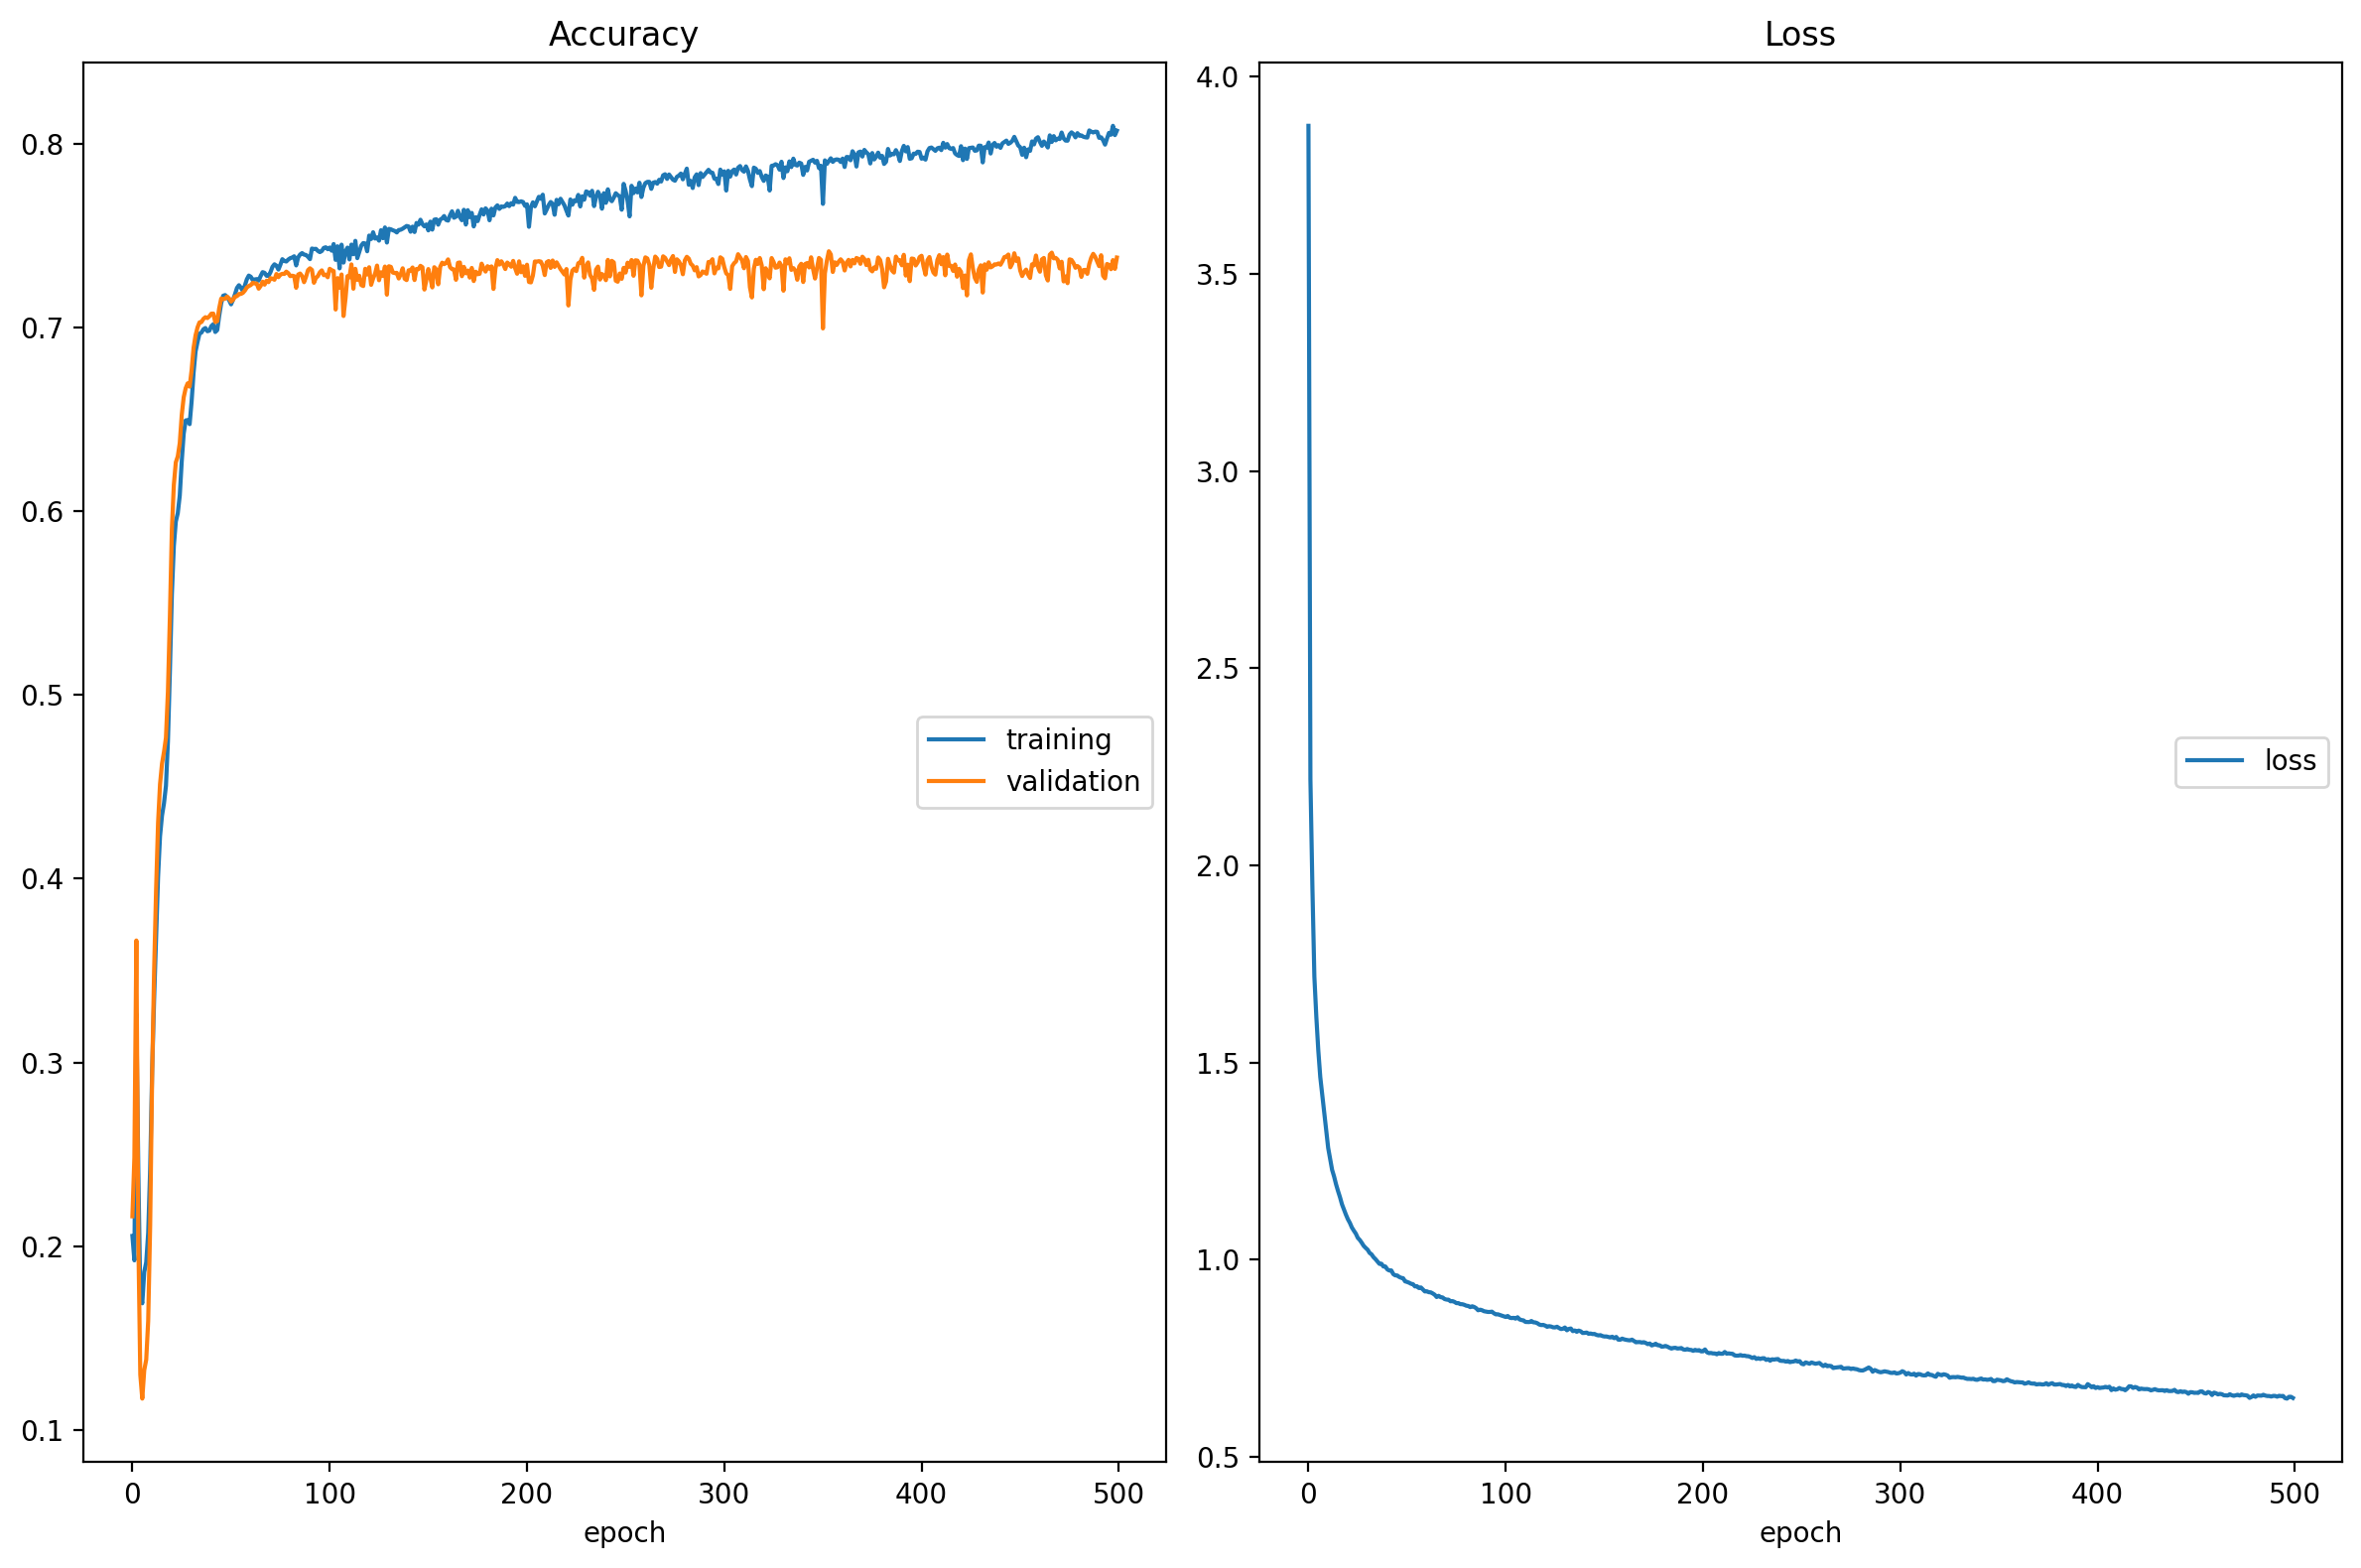

Accuracy
	training         	 (min:    0.169, max:    0.810, cur:    0.807)
	validation       	 (min:    0.117, max:    0.742, cur:    0.738)
Loss
	loss             	 (min:    0.647, max:    3.875, cur:    0.649)
time: 12min 23s (started: 2021-03-11 17:44:11 -05:00)


In [9]:
train_model(ds, model, evaluator)

### Train on Adversary Data

In [10]:
ds = data_utils.ArxivNodeDataset(device, split='adv')    
evaluator = Evaluator(name='ogbn-arxiv')

time: 1.33 s (started: 2021-03-11 17:56:34 -05:00)


In [11]:
model = data_utils.GCN(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

time: 10.2 ms (started: 2021-03-11 17:56:35 -05:00)


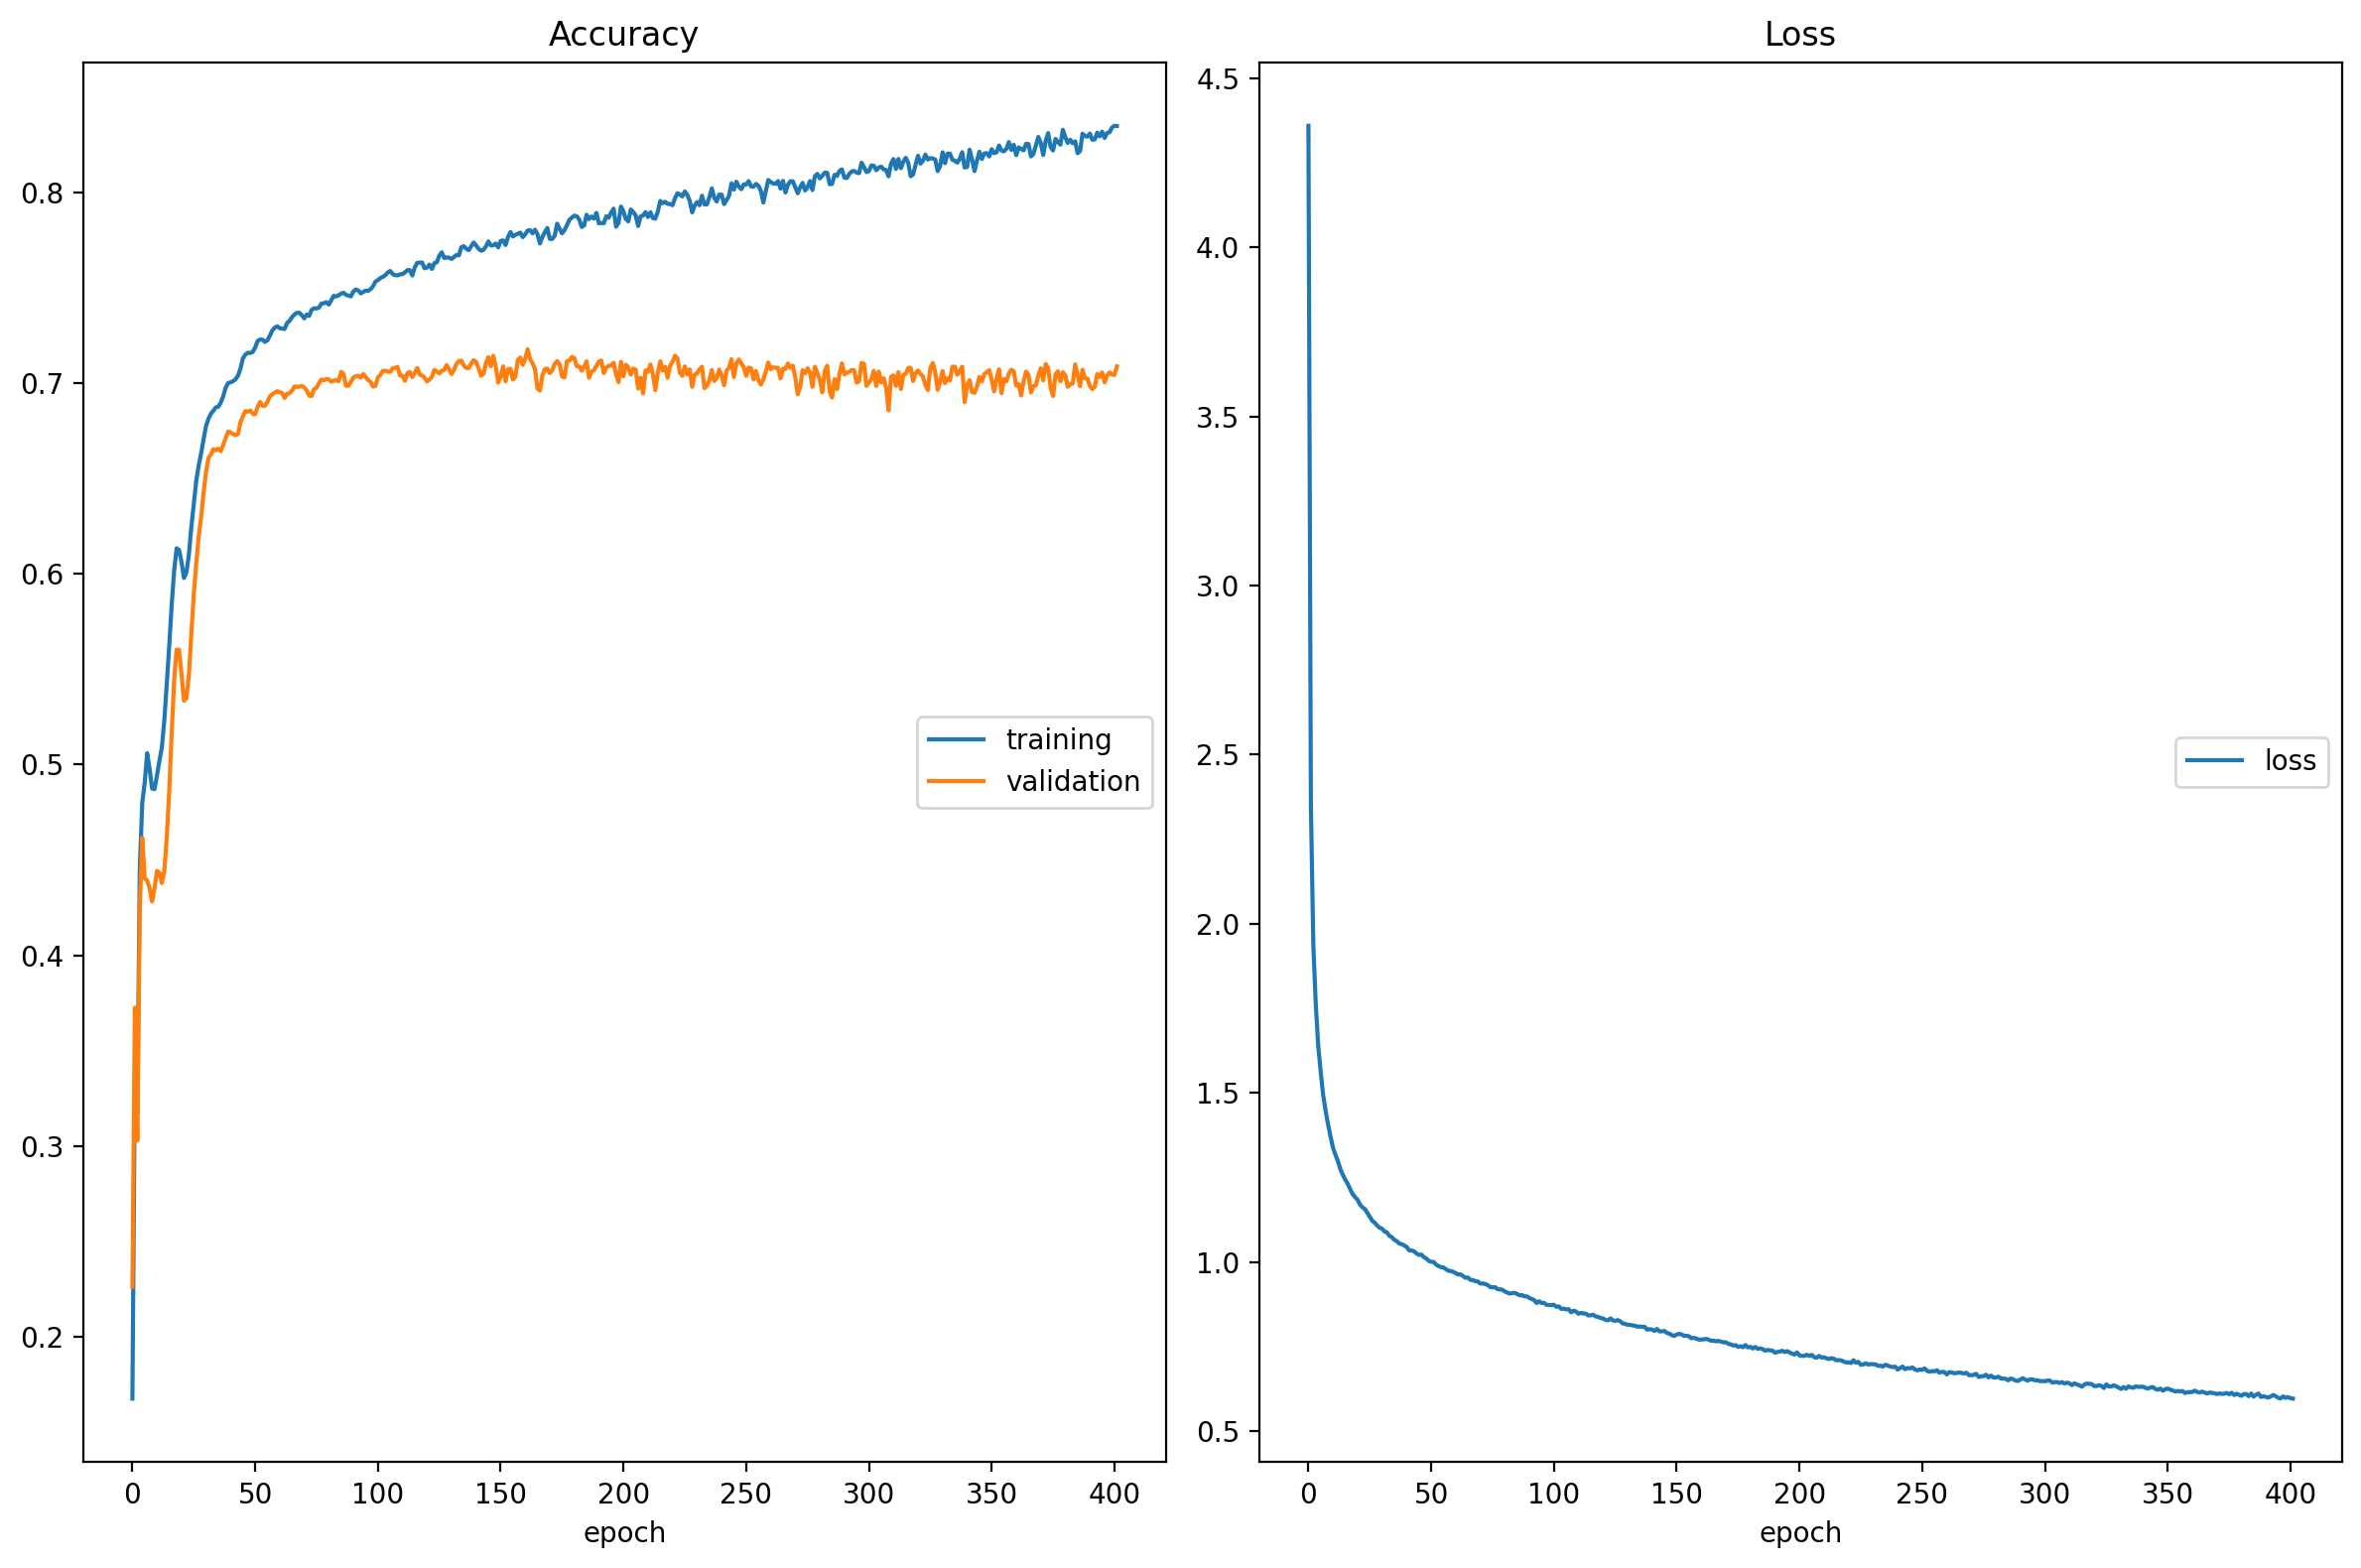

Accuracy
	training         	 (min:    0.167, max:    0.835, cur:    0.835)
	validation       	 (min:    0.226, max:    0.718, cur:    0.709)
Loss
	loss             	 (min:    0.596, max:    4.359, cur:    0.596)


In [ ]:
train_model(ds, model, evaluator)

## SAGE Models

### Train on Victim Data

In [ ]:
ds = data_utils.ArxivNodeDataset(device, split='victim')    
evaluator = Evaluator(name='ogbn-arxiv')

In [ ]:
model = data_utils.SAGE(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

In [ ]:
train_model(ds, model, evaluator)

### Train on Adversary Data

In [ ]:
ds = data_utils.ArxivNodeDataset(device, split='adv')    
evaluator = Evaluator(name='ogbn-arxiv')

In [ ]:
model = data_utils.SAGE(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

In [ ]:
train_model(ds, model, evaluator)